In [ ]:
#Load libraries
install.packages(c("keras"))
install.packages("mltools")
install.packages("data.table")
install.packages("pROC")
install.packages("cvms")
install.packages("caret")
install.packages("ggplot2")
library(mltools)
library(data.table)
library(keras)
library(tidyverse)
library(tensorflow)
library(pROC)
library(cvms)
library(caret)
library(ggplot2)

In [ ]:
#Run code to bypass error when installing "magick" package
system('add-apt-repository -y ppa:cran/imagemagick')
system('apt-get update')
system("apt-get install libmagick++-dev")
install.packages("magick")
library(magick)

In [ ]:
#Run plotting packages
install.packages("ggimage")
install.packages("rsvg")
install.packages("ggnewscale")
library(ggimage)
library(rsvg)
library(ggnewscale)

In [ ]:
#Load Data
isolates_df <- read.csv('isolates_cc_USA_SNP.csv')
#Select variables of interest and outcome
isolates_df <- isolates_df[,c('AMR.genotypes' , 'SNP_cluster_group', 'USregion', 'season', 'collection.yr', 'min_SNP', 'Isolation_Group')]
#Factor all categorical variables and scale min_SNP
isolates_df$Isolation_Group <- as.numeric(as.factor(isolates_df$Isolation_Group)) 
isolates_df$AMR.genotypes <- as.factor(isolates_df$AMR.genotypes)
isolates_df$SNP_cluster_group <- as.factor(isolates_df$SNP_cluster_group)
isolates_df$USregion <- as.factor(isolates_df$USregion)
isolates_df$season <- as.factor(isolates_df$season)
isolates_df$collection.yr <- as.factor(isolates_df$collection.yr)
isolates_df$min_SNP <- scale(isolates_df$min_SNP)
#Take complete cases
isolates <- isolates_df[complete.cases(isolates_df),]
#Create input matrix
isolates_mat <- model.matrix(Isolation_Group~AMR.genotypes + SNP_cluster_group + min_SNP + USregion + season + collection.yr, isolates)

In [ ]:
#Identify dimensions
dim(isolates)

[1] 13312     7

In [ ]:
#Get rid of intercept in matrix
isolates_mat <- isolates_mat[,-1]

# Convert target variable values from 1, 2, 3 to 0, 1, 2
isolates$Isolation_Group <- as.numeric(isolates$Isolation_Group) - 1

# Split into test and train 
set.seed(10)
ids_train <- sample.int(nrow(isolates), size = 0.75*nrow(isolates))
train_x <- isolates_mat[ids_train,]
train_y <- isolates$Isolation_Group[ids_train]
test_x <- isolates_mat[-ids_train,] 
test_y <- isolates$Isolation_Group[-ids_train]

#store test y in vector state for comparisons later
orig_y <- test_y 

#Check dimensions of training set
dim(train_x)
length(train_y)

[1] 9984  240

[1] 9984

In [ ]:
#Generate weights

#Derive class frequencies
class_freq = table(train_y)/length(train_y)

#Calculate the inverse of the class frequencies
class_weights = as.numeric(1/class_freq)

#Rename weights
names(class_weights) <- c("0", "1", "2", "3", "4")
class_weights

#One-hot Encode Outcome
train_y <- to_categorical(train_y)
test_y <- to_categorical(test_y)


0         1         2         3         4 
59.784431  8.278607  1.592853  6.764228 11.515571

In [ ]:
# Creating the final model
model <- keras_model_sequential()
model %>% 
  layer_dense(units = ncol(train_x)/2,
              #kernel_regularizer = regularizer_l2(0.001),
              activation = "relu",
              input_shape = c(ncol(train_x))) %>% 
  #layer_dropout(rate = 0.2) %>% 
  layer_dense(units = ncol(train_x)/4,
              #kernel_regularizer = regularizer_l2(0.001),
              activation = "relu") %>% 
  layer_dense(units = 30,
              #kernel_regularizer = regularizer_l2(0.001),
              activation = "relu",
              input_shape = c(ncol(train_x))) %>% 
  layer_dense(units = 5,
              activation = "softmax")
summary(model)

Model: "sequential_2"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_10 (Dense)                   (None, 120)                     28920       
 dense_9 (Dense)                    (None, 60)                      7260        
 dense_8 (Dense)                    (None, 30)                      1830        
 dense_7 (Dense)                    (None, 5)                       155         
Total params: 38,165
Trainable params: 38,165
Non-trainable params: 0
________________________________________________________________________________


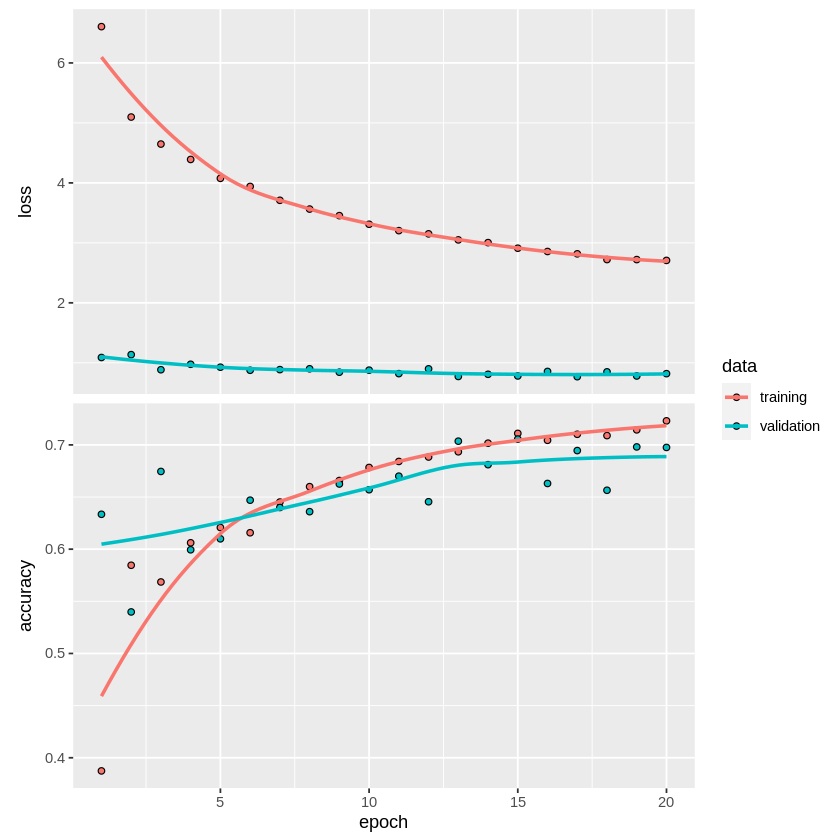

In [ ]:
# Compiling the model
tf$random$set_seed(60)
model %>% compile(loss = "categorical_crossentropy",
                  optimizer = "adam",
                  metrics = c("accuracy"))

history <- model %>% 
  fit(train_x,
      train_y,
      epoch = 20,
      batch_size = 64,
      class_weight = list("0" = 59.7844311377246, "1" = 8.27860696517413, "2" = 1.59285258455648, 
      "3" = 6.76422764227642, "4" = 11.5155709342561),
      validation_split = 0.2)

plot(history)

In [ ]:
#Get predicted probabilities for each class in a matrix output
pred_probs <- predict(model, test_x)

# Get the index of the maximum value in each row
max_index <- apply(pred_probs, 1, which.max)

# Create the new matrix (predicted matrix)
new_matrix <- matrix(0, nrow=nrow(pred_probs), ncol=ncol(pred_probs))
new_matrix[cbind(1:nrow(pred_probs), max_index)] <- 1

# Print the new matrix
tail(new_matrix)

#Check counts for each category for observed outcome
apply(test_y, 2, sum)
#Check counts for each category for predicted outcome
apply(new_matrix, 2, sum)

"[3323,]",0,1,0,0,0
"[3324,]",0,0,0,0,1
"[3325,]",0,1,0,0,0
"[3326,]",0,0,0,0,1
"[3327,]",0,0,0,0,1
"[3328,]",1,0,0,0,0


[1]   61  377 2095  502  293

[1]  284  462 1519  680  383

In [ ]:
#Derive multiclass AUC
auc_nn_multi <- sapply(1:5, function(i) multiclass.roc(orig_y, new_matrix[,i]))
auc_nn_multi

[1] 3328

[1] 3328

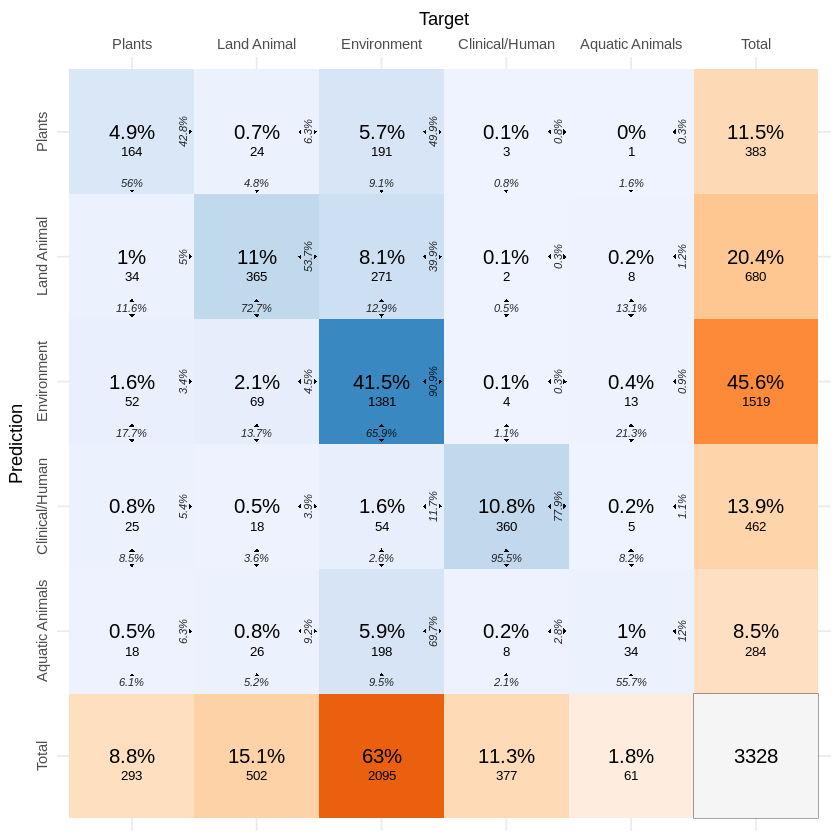

In [ ]:
#max_index
max_index_observed <- apply(test_y, 1, which.max)
length(max_index)
length(max_index_observed)

#Recreate isolation source names
observed_outcome <- case_when(max_index_observed == 1 ~ "Aquatic Animals",
          max_index_observed == 2 ~ "Clinical/Human",
          max_index_observed == 3 ~ "Environment",
          max_index_observed == 4 ~ "Land Animal",
          max_index_observed == 5 ~ "Plants")
predicted_outcome <- case_when(max_index == 1 ~ "Aquatic Animals",
          max_index == 2 ~ "Clinical/Human",
          max_index == 3 ~ "Environment",
          max_index == 4 ~ "Land Animal",
          max_index == 5 ~ "Plants")

#Plot Confusion Matrix
conf_mat <- confusion_matrix(targets = observed_outcome,
                             predictions = predicted_outcome)
plot_confusion_matrix(
  conf_mat$`Confusion Matrix`[[1]],
  add_sums = TRUE,
  sums_settings = sum_tile_settings(
    palette = "Oranges",
    label = "Total",
    tc_tile_border_color = "black"
  )
)

In [ ]:
#Output all parts of confusion matrix
confusionMatrix(table(predicted_outcome, observed_outcome))

Confusion Matrix and Statistics

                 observed_outcome
predicted_outcome Aquatic Animals Clinical/Human Environment Land Animal Plants
  Aquatic Animals              34              8         198          26     18
  Clinical/Human                5            360          54          18     25
  Environment                  13              4        1381          69     52
  Land Animal                   8              2         271         365     34
  Plants                        1              3         191          24    164

Overall Statistics
                                         
               Accuracy : 0.6923         
                 95% CI : (0.6763, 0.708)
    No Information Rate : 0.6295         
    P-Value [Acc > NIR] : 1.69e-14       
                                         
                  Kappa : 0.5298         
                                         
 Mcnemar's Test P-Value : < 2.2e-16      

Statistics by Class:

                     Class: Aqua